# Diabetes Prediction

## Loading Dataset

In [139]:
import pandas as pd

In [140]:
data = pd.read_csv('diabetes_prediction_dataset.csv')
data.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


## Data Preprocessing

In [142]:
import numpy as np

In [143]:
data.loc[data["smoking_history"] == "No Info", "smoking_history"] = np.nan
data.loc[data['smoking_history'] == 'current', 'smoking_history'] = 1
data.loc[data['smoking_history'] == 'never', 'smoking_history'] = 0
data.loc[data['smoking_history'] == 'ever', 'smoking_history'] = 0
data.loc[data['smoking_history'] == 'not current', 'smoking_history'] = 0
data.loc[data['smoking_history'] == 'former', 'smoking_history'] = 2


data.loc[data['gender'] == 'Male', 'gender'] = 1
data.loc[data['gender'] == 'Female', 'gender'] = 0
data.loc[data['gender'] == 'Other', 'gender'] = 2

In [144]:
data.smoking_history.unique()

array([0, nan, 1, 2], dtype=object)

In [145]:
data = data.dropna()

In [146]:
from sklearn.preprocessing import StandardScaler

In [147]:
data_num = data[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
data_rest = data.drop(['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'], axis=1)
scalar = StandardScaler()
data_num_scaled = scalar.fit_transform(data_num)
data_num_scaled = pd.DataFrame(data_num_scaled, columns=scalar.get_feature_names_out())

In [148]:
data = pd.concat([data_num_scaled.reset_index(), data_rest.reset_index()], axis=1)

In [149]:
data = data.drop(['index'], axis=1)

## Exploratory Data Analysis

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats

In [151]:
has_diabetes = data[data['diabetes'] == 1]
no_diabetes = data[data['diabetes'] == 0]

In [152]:
random_rows = []
for row in range(0, 7046):
    rand_index = np.random.randint(0, 7046)
    random_rows.append(rand_index)

In [153]:
no_diabetes = no_diabetes.iloc[random_rows].reset_index()
no_diabetes = no_diabetes.drop(['index'], axis=1)

In [154]:
balanced_df = pd.concat([no_diabetes.reset_index(), has_diabetes.reset_index()], axis=0)
balanced_df = balanced_df.drop(['index'], axis=1)

In [155]:
balanced_df

,age,bmi,HbA1c_level,blood_glucose_level,gender,hypertension,heart_disease,smoking_history,diabetes
0,0.483920,-0.169444,0.854140,-0.323207,0,0,0,0,0
1,-0.590788,-0.169444,-0.515085,-1.176984,0,0,0,1,0
2,-1.153731,1.532482,0.580295,0.483138,0,0,0,0,0
3,1.660982,0.137486,0.854140,-0.323207,1,1,0,0,0
4,0.023331,0.594811,-0.515085,-0.228343,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
7041,1.405099,0.166644,2.405927,-0.228343,0,0,0,1,1
7042,0.944510,0.786643,2.405927,0.008817,0,1,1,0,1
7043,0.432744,0.306297,0.580295,3.803382,1,0,1,2,1
7044,0.586273,1.517135,1.310548,1.431779,0,1,0,0,1


#### Average age of Diabetes Person

In [156]:
has_diabetes_age_avg = np.average(has_diabetes['age'])
has_diabetes_std = np.std(has_diabetes['age'])
print(f'The average age of a person that has diabetes is {has_diabetes_age_avg:.2f} with a standard deviation of {has_diabetes_std:.2f}')

The average age of a person that has diabetes is 0.74 with a standard deviation of 0.72


#### Checking for highly correlated features

<AxesSubplot: >

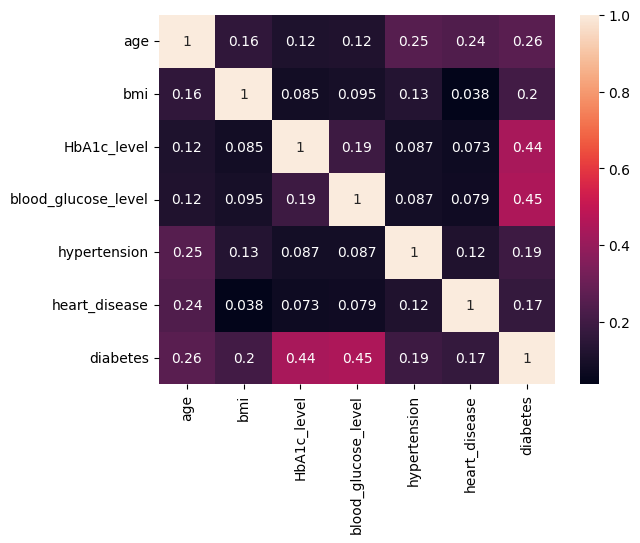

In [157]:
data_num_only = data.select_dtypes(['int64', 'float64'])
data_num_corr = data_num_only.corr()
sns.heatmap(data_num_corr, annot=True)

## Model Creation

In [158]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [159]:
X = balanced_df.drop(['diabetes'], axis=1)
y = balanced_df['diabetes']

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [161]:
param_grid = {
    'penalty' : ['l2'],
    'solver' : ['lbfgs', 'liblinear', 'newton-cholesky']
}

lgr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(estimator=lgr, param_grid=param_grid, cv=5)

In [162]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cholesky']})

In [163]:
print(f'Best Parameters : {grid_search.best_params_}')
print(f'Best Score : {grid_search.best_score_:.2f}')

Best Parameters : {'penalty': 'l2', 'solver': 'liblinear'}
Best Score : 0.88


### Finding optimal features using Wrapping Methods

In [169]:
import statsmodels.api as sm

In [168]:
p_level = 0.05
LGR = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
LGR.fit(X_train, y_train)

features = X_train.columns.tolist()
while len(features) > 0:


LogisticRegression(max_iter=1000, solver='liblinear')

### Training the Model

## Model Evaluation

In [165]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#### Applying Cross Validation

#### Confusion Matrix

In [166]:
y_pred = LGR.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[1222  171]
 [ 180 1246]]


In [167]:
f1 = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1 score : {f1:.2f}')

F1 score : 0.88


#### Saving the Model